In [1]:
import sys
sys.path.append('/lmh_data/work/sclab/train/')

import numpy as np
import pandas as pd
import torch
import torch.utils.data as data
from torch.autograd import Variable
from captum.attr import IntegratedGradients

from dataset import Dataset
from net import define_network

In [2]:
torch.manual_seed(123)
np.random.seed(123)

In [3]:
def evaluate(eval_file, model_file, gene_name):
    eval_set = Dataset(eval_file, gene_name, is_train=True)
    data_loader = data.DataLoader(eval_set, batch_size=1, shuffle=False)

    input_size, output_size = tuple(eval_set[0][0].shape), eval_set[0][1].shape[0]
    patch_size = tuple([int(i / 8) for i in input_size])
    model = torch.nn.DataParallel(define_network(input_size, patch_size, output_size))
    model.load_state_dict(torch.load(model_file))
    model.cuda()
    model.eval()
    ig = IntegratedGradients(model)

    _datas = np.load(eval_file, allow_pickle=True)
    important_genes = dict(Astro=dict(), Endo=dict(), OPC=dict(), ODC=dict())
    for index, batch in enumerate(data_loader, 1):
        if _datas[index-1]['cell_type'] != 'Astro':
            continue
        _important_genes = important_genes[_datas[index-1]['cell_type']]
        input = Variable(batch[0]).cuda().unsqueeze(1)
        target = Variable(batch[1]).cuda().unsqueeze(1) / 10
        
        attributions = torch.zeros(input.reshape(-1).shape).cuda()
        for i in range(target.shape[-1]):
            attributions += ig.attribute(input, target=(0, i))[0, 0].reshape(-1)
        attributions = attributions.cpu().detach().numpy()
        for i in range(len(attributions)):
            if i not in _important_genes.keys():
                _important_genes[i] = 0
            _important_genes[i] += attributions[i]
        
    return important_genes

important_genes = evaluate(
    '/lmh_data/data/sclab/sclab/promoter/eval_dataset.npy',
    '/lmh_data/data/sclab/sclab/promoter/tmp/SLC1A2/model_epoch_8.pth', 'SLC1A2')
important_genes

{'Astro': {0: 0.0,
  1: 0.0,
  2: 0.0,
  3: 0.0,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0,
  8: 0.0,
  9: 0.0,
  10: 0.0,
  11: 0.0,
  12: 0.0,
  13: 0.0,
  14: 0.0,
  15: 0.0,
  16: 0.0,
  17: 0.0,
  18: 0.046677907928824425,
  19: -0.03831783356145024,
  20: -0.012686114758253098,
  21: 0.0,
  22: -0.01783061819151044,
  23: 0.006919299252331257,
  24: -0.027189903426915407,
  25: 0.0,
  26: 0.043402837589383125,
  27: 0.0,
  28: 0.0,
  29: 0.0,
  30: 0.0,
  31: 0.0,
  32: 0.0,
  33: 0.0,
  34: -0.024832261726260185,
  35: 0.0,
  36: 0.0,
  37: -0.017659807112067938,
  38: -0.021067813970148563,
  39: 0.044802322052419186,
  40: 0.0,
  41: 0.04666308779269457,
  42: 0.0,
  43: -0.011376258684322238,
  44: -0.006567602977156639,
  45: -0.06428107246756554,
  46: -0.059894919861108065,
  47: -0.06848045997321606,
  48: 0.0,
  49: 0.0,
  50: 0.0013426216319203377,
  51: 0.0,
  52: 0.10980545915663242,
  53: 0.015950648114085197,
  54: -0.013395476154983044,
  55: -0.03652900457382202,
  5

In [4]:
scRNA_head = np.load('/lmh_data/data/sclab/sclab/promoter/eval_dataset.npy', allow_pickle=True)[0]['scRNA_head']

def find_special_genes(important_genes, cell_type):
    genes = pd.DataFrame(
        sorted(important_genes[cell_type].items(), key=lambda x: x[1], reverse=True), columns=['index', 'value']
    ).set_index('index')
    genes = genes.sort_values(by=['value'], ascending=False)
    return genes

genes = find_special_genes(important_genes, 'Astro')
genes['name'] = scRNA_head[list(genes.index)]
genes.to_csv('tmp/related_genes_SLC1A2_promoter.csv')
genes

,value,name
index,,
15794,81.880256,MALAT1
15264,50.705262,SLC1A2
18428,41.907643,PCDH9
7265,27.020140,GPM6A
5505,23.289210,LSAMP
...,...,...
23665,-7.329595,DTNA
8227,-7.533408,PPP2R2B
23811,-9.002192,CDH20


In [5]:
genes = genes[:100]
gene_names = genes.name.values
gene_names

array(['MALAT1', 'SLC1A2', 'PCDH9', 'GPM6A', 'LSAMP', 'ERBB4', 'NPAS3',
       'GPC5', 'NRXN1', 'CTNND2', 'SPARCL1', 'NTRK2', 'XIST', 'SLC1A3',
       'CST3', 'ZBTB20', 'MAPK10', 'NTM', 'ANK2', 'FBXL7', 'ARHGAP24',
       'RORA', 'DPP10', 'RYR3', 'TRPM3', 'NKAIN3', 'PTPRG', 'PITPNC1',
       'FAM171B', 'FTH1', 'LRRC16A', 'MEIS2', 'QKI', 'PLCB1', 'ZSWIM6',
       'FTX', 'DOCK4', 'BMPR1B', 'AUTS2', 'WIF1', 'PTK2', 'NEBL', 'ADCY2',
       'PPAP2B', 'NFIB', 'PREX2', 'LRRC4C', 'LINC00299', 'RGS7', 'NRG3',
       'KCNMA1', 'NFIA', 'PSD3', 'HSPA1A', 'TJP1', 'TMEM108', 'PTPRZ1',
       'LIFR', 'AHCYL2', 'N4BP2L2', 'NAV3', 'GLUD1', 'ZHX3', 'SLC7A11',
       'PHLPP1', 'ZFHX4', 'PAMR1', 'CAMTA1', 'TRIM2', 'PRTFDC1', 'MED13L',
       'SORBS1', 'RERE', 'RFX3', 'CADM1', 'PHACTR3', 'CALM2', 'PNISR',
       'PDE4B', 'DYNC2H1', 'LRIG1', 'ASTN2', 'ZNF638', 'JMJD1C', 'TCF4',
       'ACSL6', 'SLC4A4', 'GLUL', 'AQP4', 'FGFR2', 'PSD2', 'HNRNPA2B1',
       'SLCO1C1', 'SCD5', 'NCAM2', 'PHF14', 'MID1', 'DOCK3'

In [6]:
literome = pd.read_csv('/lmh_data/data/sclab/source/literome/pathway-extraction.txt', sep='\t')

def get_filter(gene_name, num=0):
    if num == 2:
        return pd.DataFrame()
    _filter_Causes = literome[literome.Theme.str.contains(gene_name)].Cause.str.split(':').str[-1].str.split('_')
    _filter_Themes = literome[literome.Cause.str.contains(gene_name)].Theme.str.split(':').str[-1].str.split('_')
    _filter_genes = set()
    for _filter in pd.concat([_filter_Causes, _filter_Themes]).values:
        _filter_genes = _filter_genes | set(_filter)
    _filters = [get_filter(_name, num+1) for _name in _filter_genes]
    _filters.append(_filter_Causes)
    _filters.append(_filter_Themes)
    return pd.concat(_filters)

_filters = get_filter('SLC1A2')

In [7]:
_filter_genes = set()
for _filter in _filters.values:
    _filter_genes = _filter_genes | set(_filter[0])
print(len(_filter_genes & set(gene_names)) / len(gene_names))
_filter_genes & set(gene_names)

0.02


{'SLC1A2', 'SLC1A3'}

In [8]:
_filter_genes

{'ALDH18A1', 'SLC1A2', 'SLC1A3'}

In [9]:
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(eval_file, model_file, gene_name, ignore_genes_index):
    eval_set = Dataset(eval_file, gene_name, is_train=True)
    data_loader = data.DataLoader(eval_set, batch_size=1, shuffle=False)

    input_size, output_size = tuple(eval_set[0][0].shape), eval_set[0][1].shape[0]
    patch_size = tuple([int(i / 8) for i in input_size])
    model = torch.nn.DataParallel(define_network(input_size, patch_size, output_size))
    model.load_state_dict(torch.load(model_file))
    model.cuda()
    model.eval()

    _datas = np.load(eval_file, allow_pickle=True)
    pearsons = []
    for index, batch in enumerate(data_loader, 1):
        if _datas[index-1]['cell_type'] != 'Astro':
            continue
        input = Variable(batch[0]).cuda().unsqueeze(1)
        target = Variable(batch[1]).cuda().unsqueeze(1).cpu().numpy()
        
        _shape = input.shape
        input = input.reshape(-1)
        input[ignore_genes_index] = 0
        input = input.reshape(_shape)
        output = model(input).detach().cpu().numpy()
        
        pearson = stats.pearsonr(output[0, 0], target[0, 0])[0]
        pearsons.append(pearson)
        
    return pearsons

In [10]:
ignore_preds_info = []
for i in range(0, 101, 10):
    pearsons = evaluate(
        '/lmh_data/data/sclab/sclab/promoter/eval_dataset.npy',
        '/lmh_data/data/sclab/sclab/promoter/tmp/SLC1A2/model_epoch_8.pth', 'SLC1A2', list(genes.index)[:i])
    _df = pd.DataFrame({'pearson': pearsons, 'ignore proportion': i})
    ignore_preds_info.append(_df)

ignore_preds_info = pd.concat(ignore_preds_info, axis=0, ignore_index=True)

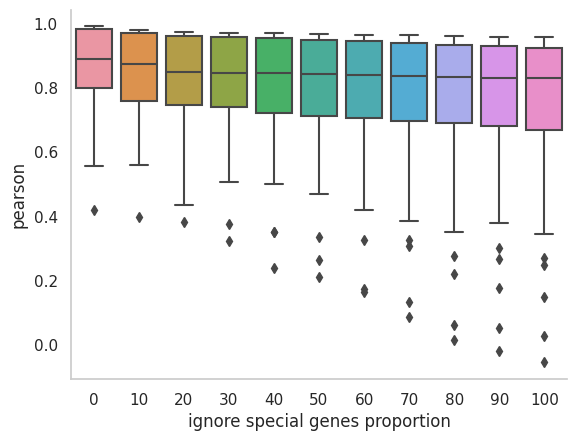

In [11]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(
    x='ignore proportion', y='pearson', data=ignore_preds_info
)

sns.despine()
plt.grid(False)

plt.xlabel("ignore special genes proportion")
plt.ylabel("pearson")

plt.show()

Text(0, 0.5, 'pearson')

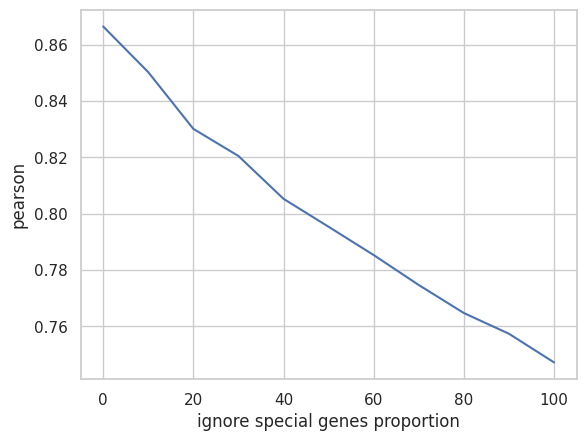

In [12]:
_group_by = ignore_preds_info.groupby('ignore proportion').mean()
x, y = _group_by.index, _group_by.values.flatten()
plt.plot(x, y)
plt.xlabel("ignore special genes proportion")
plt.ylabel("pearson")

In [13]:
ignore_preds_info = []
for i in range(0, 101, 10):
    pearsons = evaluate(
        '/lmh_data/data/sclab/sclab/promoter/eval_dataset.npy',
        '/lmh_data/data/sclab/sclab/promoter/tmp/SLC1A2/model_epoch_8.pth', 'SLC1A2', list(genes.index)[max(i-10, 0):i])
    _df = pd.DataFrame({'pearson': pearsons, 'ignore proportion': i})
    ignore_preds_info.append(_df)

ignore_preds_info = pd.concat(ignore_preds_info, axis=0, ignore_index=True)

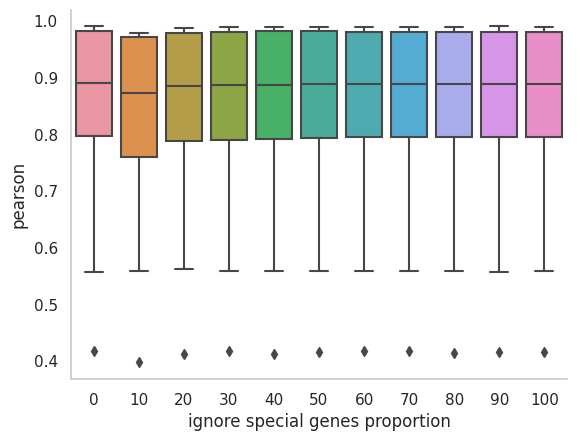

In [14]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(
    x='ignore proportion', y='pearson', data=ignore_preds_info
)

sns.despine()
plt.grid(False)

plt.xlabel("ignore special genes proportion")
plt.ylabel("pearson")

plt.show()

Text(0, 0.5, 'pearson')

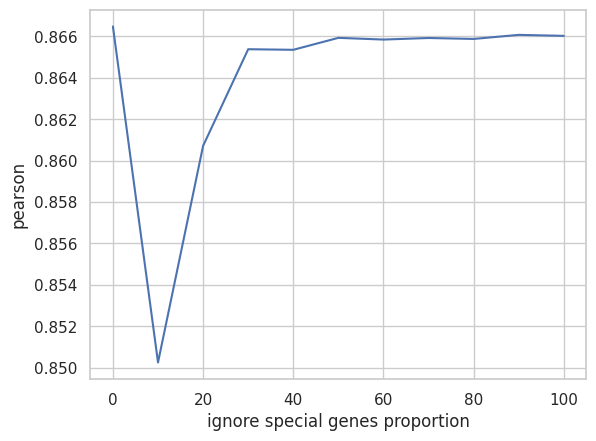

In [15]:
_group_by = ignore_preds_info.groupby('ignore proportion').mean()
x, y = _group_by.index, _group_by.values.flatten()
plt.plot(x, y)
plt.xlabel("ignore special genes proportion")
plt.ylabel("pearson")

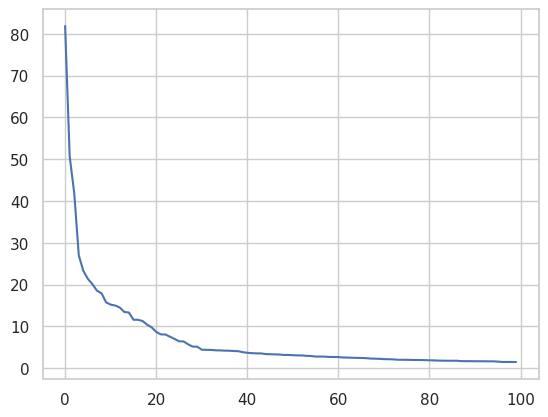

In [16]:
y = genes.value.values.flatten()

x = [i for i in range(len(y))]
plt.plot(x, y)